# Advanced Problem Answers

## Metaprogramming Problem

In [28]:
macro myevalpoly(z,a...)
    isempty(a) && error("You forgot to pass coefficients!")
    ex = :($(a[length(a)]))
    for i in 1:length(a)-1
       ex = :($ex * $(z) + $(a[length(a)-i]) ) 
    end
    println(ex)
    ex
end

@myevalpoly (macro with 1 method)

In [29]:
@myevalpoly 7 2 3 4 5

((5 * 7 + 4) * 7 + 3) * 7 + 2


1934

In [26]:
@evalpoly 7 2 3 4 5

1934

## Plot the roots of Wilkinson's polynomial with perturbation

First, we need to construct coefficients $a_k$. For the polynomial $\prod_{i=1}^4 (x-z_i)$, we have the coefficients $$\left(
\begin{array}{c}
 z_1 z_2 z_3 z_4 \\
 -z_1 z_2 z_3-z_1 z_4 z_3-z_2 z_4 z_3-z_1 z_2 z_4 \\
 z_1 z_2+z_3 z_2+z_4 z_2+z_1 z_3+z_1 z_4+z_3 z_4 \\
 -z_1-z_2-z_3-z_4 \\
 1 \\
\end{array}
\right),$$ thus we can exploit the structure and write a double `for` loop to calculate the coefficients. A more general formula is 
$$
\begin{cases}
1 = a_{n}\\
x_{1}+x_{2}+\dots +x_{n-1}+x_{n}=-a_{n-1}\\
(x_{1}x_{2}+x_{1}x_{3}+\cdots +x_{1}x_{n})+(x_{2}x_{3}+x_{2}x_{4}+\cdots +x_{2}x_{n})+\cdots +x_{n-1}x_{n}=a_{n-2}\\
\quad \vdots \\
x_{1}x_{2}\dots x_{n}=(-1)^{n}a_{0}.\end{cases}
$$
Checkout [Vieta's formulas](https://en.wikipedia.org/wiki/Vieta%27s_formulas) for more information.

In [1]:
function root2coeff(z::AbstractVector{T}) where T
    N = length(z)
    co = zeros(T, N+1)
    # The last coefficient is always one
    co[end] = 1
    # The outer loop adds one root at a time
    for j in 1:N, i in j:-1:1
        co[end-i] -= z[j]*co[end-i+1]
    end
    co
end
@show typemax(Int), typemax(Int128)
root2coeff(1:20)

(typemax(Int), typemax(Int128)) = (9223372036854775807, 170141183460469231731687303715884105727)


21-element Array{Int64,1}:
  2432902008176640000
 -8752948036761600000
 -4642984320068847616
  5575812828558562816
  8037811822645051776
 -3599979517947607200
  1206647803780373360
  -311333643161390640
    63030812099294896
   -10142299865511450
     1307535010540395
     -135585182899530
       11310276995381
        -756111184500
          40171771630
          -1672280820
             53327946
             -1256850
                20615
                 -210
                    1

Those numbers are close to `typemax(Int)`, so integer overflows may occur, lets use `Int128` instead.

In [2]:
root2coeff(Int128(1):20)

21-element Array{Int128,1}:
   2432902008176640000
  -8752948036761600000
  13803759753640704000
 -12870931245150988800
   8037811822645051776
  -3599979517947607200
   1206647803780373360
   -311333643161390640
     63030812099294896
    -10142299865511450
      1307535010540395
      -135585182899530
        11310276995381
         -756111184500
           40171771630
           -1672280820
              53327946
              -1256850
                 20615
                  -210
                     1

Next, we need to construct a [companion matrix](https://en.wikipedia.org/wiki/Companion_matrix) and solve for roots.
A companion matrix is in the form of
$$
\begin{bmatrix}0&0&\dots &0&-z_{1}\\1&0&\dots &0&-z_{2}\\0&1&\dots &0&-z_{3}\\\vdots &\vdots &\ddots &\vdots &\vdots \\0&0&\dots &1&-z_{n-1}\end{bmatrix}.
$$

In [3]:
function poly_roots(z)
    len = length(z)
    # construct the ones part
    mat = diagm(ones(len-2), -1)
    # insert coefficients
    mat[:, end] = -z[1:end-1]
    eigvals(mat)
end

poly_roots (generic function with 1 method)

We have everything ready now. We just need to calculate all the roots and plot it.

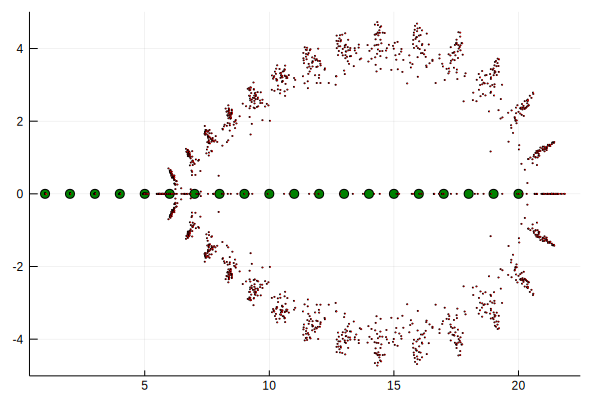

In [4]:
srand(1)
function wilkinson_poly_roots(n=100)
    # original coefficients
    coeff = root2coeff(Int128(1):20)
    rts = Vector{Complex{Float64}}[]
    # add perturbation
    for i in 1:n
        pert_coeff = coeff.*(1+rand(21)*1e-10)
        push!(rts, poly_roots(pert_coeff))
    end
    rts
end
using Plots; gr()
function plt_wilkinson_roots(rts)
    # plot roots without perturbation
    plt = scatter(1:20, zeros(20), color = :green, markersize = 5, legend=false)
    for i in eachindex(rts)
        # plot roots with perturbation
        scatter!(plt, real.(rts[i]), imag.(rts[i]), color = :red, markersize = .5)
    end
    plt
end
wilkinson_poly_roots() |> plt_wilkinson_roots